In [66]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df_log = pd.read_csv('train_cleaned_v.2.csv')
df_unscaled = pd.read_csv('train_cleaned_v.1.csv')

In [67]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import plotly.graph_objects as go

# Supponiamo che 'df_log' sia il DataFrame contenente le variabili log trasformate
# Selezionare solo le variabili numeriche
df_numeric = df_log.select_dtypes(include=[float, int])

# Standardizzare i dati prima di applicare la PCA
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df_numeric)

# Applicare la PCA con 5 componenti principali
num_components = 5
pca = PCA(n_components=num_components)
principal_components = pca.fit_transform(df_standardized)

# Creare un DataFrame con le componenti principali
df_pca = pd.DataFrame(data=principal_components, columns=[f'Principal Component {i+1}' for i in range(num_components)])

# Aggiungere i nomi delle variabili originali come indice del DataFrame
df_pca.index = df_numeric.index

# Visualizzare la variabilità spiegata delle variabili
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'Principal Component {i+1}' for i in range(num_components)],
    'Explained Variance Ratio': explained_variance_ratio[:num_components]
})

# Calcolare la somma totale della variabilità spiegata
total_explained_variance = explained_variance_ratio.sum()
print(f"Total Explained Variance: {total_explained_variance}")

# Loadings (senza rotazione)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Creare un DataFrame per i loadings con i nomi delle variabili
loadings_df = pd.DataFrame(loadings, index=df_numeric.columns, columns=[f'Principal Component {i+1}' for i in range(num_components)])

# Calcolare la stima delle comunanze finali
communalities = np.sum(loadings_df**2, axis=1)
communalities_df = pd.DataFrame(communalities, columns=['Communalities'])

# Visualizzare le comunanze finali
print(communalities_df)

# Visualizzare i loadings
print(loadings_df)

# Creare lo scree plot con linee e punti utilizzando Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=explained_variance_df['Principal Component'],
    y=explained_variance_df['Explained Variance Ratio'],
    mode='lines+markers',
    name='Explained Variance Ratio'
))

fig.update_layout(
    title='Scree Plot',
    xaxis_title='Principal Component',
    yaxis_title='Explained Variance Ratio'
)

fig.show()

Total Explained Variance: 0.7652830822852068
                 Communalities
startYear             0.835363
runtimeMinutes        0.801539
awardWins             0.864078
numVotes              0.800600
totalImages           0.644825
totalVideos           0.776888
totalCredits          0.525670
AwNmExWins            0.823553
numRegions            0.710280
ratingMean            0.781926
ReviewsTotal          0.804658
popularityIndex       0.814593
                 Principal Component 1  Principal Component 2  \
startYear                     0.070400               0.649453   
runtimeMinutes                0.313851              -0.320829   
awardWins                     0.529479               0.390197   
numVotes                      0.796760              -0.225597   
totalImages                   0.701491              -0.164419   
totalVideos                   0.719083               0.130729   
totalCredits                  0.643103               0.172292   
AwNmExWins                    0.

The number of components have been choosen based on the explained variability. Based on screeplot the component were 2 or 3, but 5 component represent the 77% of the informations.  
  
From the estimate of the final communalities all variable are well explained. Only totalCredits have a lower value.  
From the PCA it can be seen that the first component is representative of many instances: numVotes, totalImages, totalVideos, totalCredits, AwNmExWins, numRegions, ReviewsTotal, popularityIndex. So it's a general misure of popularity.  
The second component is representative of startYear and ratingMean so it's a misure of how recently and the rating of a film.
The PC3 have a high value in awardWins and AwNmExWins so it's a dimension of the success of the title.
The PC4 make the Distinzione tra film più vecchi e lunghi con meno video e rating medi più alti
The fifth component is a measure of modernity and duration.

In [68]:
# Calcola SSE e Silhouette Score per diversi valori di k per scegliere il numero di cluster
sse_list = []
sil_list = []
k_values = range(2, 21)  # Prova valori di k da 2 a 20

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(principal_components)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(principal_components, clusters))

# Crea la figura con due sottotrame (subplots)
fig = make_subplots(rows=1, cols=2, subplot_titles=("SSE vs k", "Silhouette Score vs k"))

# Grafico SSE vs k
fig.add_trace(
    go.Scatter(x=list(k_values), y=sse_list, mode='lines+markers', name="SSE"),
    row=1, col=1
)
fig.update_xaxes(title_text="k", row=1, col=1)
fig.update_yaxes(title_text="SSE", row=1, col=1)

# Grafico Silhouette Score vs k
fig.add_trace(
    go.Scatter(x=list(k_values), y=sil_list, mode='lines+markers', name="Silhouette"),
    row=1, col=2
)
fig.update_xaxes(title_text="k", row=1, col=2)
fig.update_yaxes(title_text="Silhouette Score", row=1, col=2)

# Layout generale della figura
fig.update_layout(title_text="SSE e Silhouette Score per il clustering K-Means",
                  showlegend=False)

# Mostra il grafico
fig.show()

In [69]:
# Esegui il clustering K-means sui dati trasformati dalla PCA
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(principal_components)

# Aggiungi i cluster al DataFrame delle componenti principali
df_pca['Cluster'] = clusters

# Calcola l'SSE (Sum of Squared Errors)
sse = kmeans.inertia_
print(f"SSE (Sum of Squared Errors): {sse}")

# Calcola il Silhouette Score
silhouette_avg = silhouette_score(principal_components, clusters)
print(f"Silhouette Score: {silhouette_avg}")

SSE (Sum of Squared Errors): 83507.1926178296
Silhouette Score: 0.4127352222375481


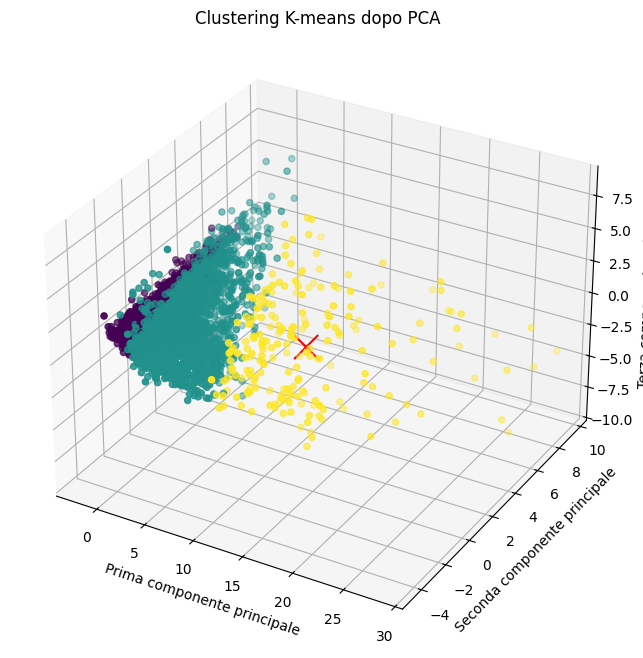

In [70]:
# Visualizza i risultati del clustering su 3 componenti principali (grafico 3D)
fig = plt.figure(figsize=(15, 8))  # Aumenta la larghezza del grafico
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_pca['Principal Component 1'], df_pca['Principal Component 2'], df_pca['Principal Component 3'], c=df_pca['Cluster'], cmap='viridis', marker='o')
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=300, c='red', marker='x')
ax.set_title('Clustering K-means dopo PCA')
ax.set_xlabel('Prima componente principale')
ax.set_ylabel('Seconda componente principale')
ax.set_zlabel('Terza componente principale')

plt.show()

In [71]:
import seaborn as sns

# Numero di simulazioni per i dati randomizzati
n_simulations = 50
sse_random_results = []
silhouette_random_results = []

# Loop per creare dati randomizzati e calcolare SSE e Silhouette
for _ in range(n_simulations):
    random_data = np.random.permutation(principal_components)  # Shuffle dei dati standardizzati
    random_kmeans = KMeans(n_clusters=3, random_state=42)
    random_clusters = random_kmeans.fit_predict(random_data)
    sse_random_results.append(random_kmeans.inertia_)
    silhouette_random_results.append(silhouette_score(random_data, random_clusters))

# SSE e Silhouette Score sui dati reali
sse_real = kmeans.inertia_
silhouette_real = silhouette_score(principal_components, clusters)

# Visualizza i risultati di SSE per i dati reali e randomizzati
plt.figure(figsize=(10, 10))

# Plotta gli histogrammi per SSE
plt.subplot(2, 1, 1)
sns.histplot(sse_random_results, kde=True, label='Randomized SSE', color='blue', stat='density', bins=10)
plt.axvline(x=sse_real, color='red', linestyle='--', label='Real SSE')
plt.legend()
plt.title('SSE Comparison')

# Plotta gli histogrammi per Silhouette
plt.subplot(2, 1, 2)
sns.histplot(silhouette_random_results, kde=True, label='Randomized Silhouette', color='blue', stat='density', bins=30)
plt.axvline(x=silhouette_real, color='red', linestyle='--', label='Real Silhouette')
plt.legend()
plt.title('Silhouette Score Comparison')

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Vengono scelti 4 cluster perchè il valore del silhoutte score è piu alto di quello randomico mantenendo comunque sse molto piu basso di quelli randomici

In [ ]:
from plotly.subplots import make_subplots

#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from kneed import KneeLocator

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

n_points = principal_components.shape[0]
#generate distance matrix
distance_matrix = squareform(pdist(principal_components, metric='euclidean')) 

#Otteniamo le etichette di cluster dal modello k-means
labels = kmeans.labels_

#generate ideal similarity matrix
similarity_matrix = np.equal.outer(labels, labels).astype(int)


# Convertiamo la matrice delle distanze in una matrice di similarità
# (simply similarity_matrix = max_distance - distance_matrix)
max_distance = np.max(distance_matrix)
similarity_from_distance = distance_matrix - max_distance 

'''
# Rendi entrambe le matrici 1D per il calcolo della correlazione
similarity_from_distance_flat = similarity_from_distance.flatten()
similarity_matrix_flat = similarity_matrix.flatten()

# Calcola la correlazione di Pearson
correlation, _ = pearsonr(similarity_from_distance_flat, similarity_matrix_flat)

print("Correlation between distance and ideal similarity matrices:", correlation)
'''
# Selezioniamo solo la parte inferiore della matrice, inclusa la diagonale
lower_triangle_indices = np.tril_indices(n_points)

# Appiattiamo solo la parte inferiore della matrice
similarity_from_distance_flat = similarity_from_distance[lower_triangle_indices]
similarity_matrix_flat = similarity_matrix[lower_triangle_indices]

# Calcolare la correlazione di Pearson tra i vettori appiattiti
correlation, _ = pearsonr(similarity_from_distance_flat, similarity_matrix_flat)

print("Correlation between distance and ideal similarity matrices:", correlation)

Correlation between distance and ideal similarity matrices: -0.546901058549819


In [ ]:
principal_components_df = pd.DataFrame(principal_components)
principal_components_df.describe()

,0,1,2,3,4
count,1.592500e+04,1.592500e+04,1.592500e+04,1.592500e+04,1.592500e+04
mean,-4.818751e-17,8.031252e-18,1.226997e-17,-1.829341e-17,7.138891e-18
std,2.181760e+00,1.204234e+00,1.054390e+00,9.756705e-01,9.539630e-01
min,-2.035522e+00,-4.498423e+00,-8.966716e+00,-7.281044e+00,-1.142142e+01
25%,-1.188627e+00,-7.356971e-01,-5.724487e-01,-5.906491e-01,-4.708865e-01
50%,-6.414801e-01,1.211618e-01,-1.180095e-01,3.169159e-02,3.744217e-02
75%,3.607751e-01,7.627275e-01,4.360890e-01,6.272481e-01,5.347183e-01
max,2.849269e+01,9.533924e+00,8.472327e+00,4.173104e+00,7.233131e+00


In [ ]:
# Calcola le statistiche per ciascun cluster
cluster_stats = df_pca.groupby('Cluster').describe()
print("Statistiche per ciascun cluster:")
cluster_stats.transpose()

Statistiche per ciascun cluster:


Cluster                                 0            1           2
Principal Component 1 count  12709.000000  3001.000000  215.000000
                      mean      -0.777351     2.406425   12.361264
                      std        0.646651     1.635391    4.611885
                      min       -2.035522    -0.092530    7.146435
                      25%       -1.282999     1.170080    8.919916
                      50%       -0.887953     1.892419   10.965863
                      75%       -0.340668     3.179026   14.519446
                      max        2.437143     8.436222   28.492688
Principal Component 2 count  12709.000000  3001.000000  215.000000
                      mean       0.114561    -0.598193    1.577775
                      std        0.991512     1.593798    2.370988
                      min       -4.194227    -4.498423   -3.274733
                      25%       -0.497621    -1.827166   -0.044304
                      50%        0.221860    -0.727060    1.061509
                      75%        0.790991     0.388189    2.879203
                      max        4.682127     7.004439    9.533924
Principal Component 3 count  12709.000000  3001.000000  215.000000
                      mean      -0.051677     0.279661   -0.848835
                      std        0.709717     1.717202    3.081771
                      min       -2.606649    -5.156957   -8.966716
                      25%       -0.541753    -0.863506   -3.270281
                      50%       -0.143948     0.041404   -0.618293
                      75%        0.371059     1.122946    1.379850
                      max        5.006802     8.472327    6.934508
Principal Component 4 count  12709.000000  3001.000000  215.000000
                      mean      -0.046407     0.263570   -0.935746
                      std        0.839641     1.245047    2.292768
                      min       -4.034326    -6.323643   -7.281044
                      25%       -0.586000    -0.534639   -2.596545
                      50%       -0.009370     0.346619   -0.565866
                      75%        0.524712     1.136922    0.744987
                      max        3.116848     3.770001    4.173104
Principal Component 5 count  12709.000000  3001.000000  215.000000
                      mean      -0.111479     0.618554   -2.044138
                      std        0.816431     0.904859    2.521011
                      min       -3.687256    -2.589325  -11.421423
                      25%       -0.551503     0.072156   -3.162940
                      50%       -0.057281     0.561778   -1.335862
                      75%        0.391643     1.085128   -0.279626
                      max        3.964384     7.233131    1.616490